/home/augustinm/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
  7%|▋         | 19/273 [00:00<00:01, 183.60it/s]

clouds


100%|██████████| 273/273 [00:01<00:00, 200.18it/s]


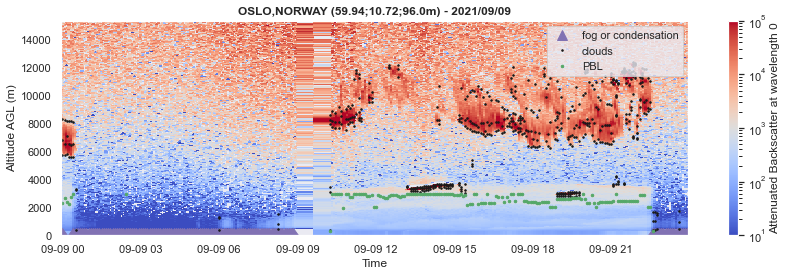

In [1]:
import aprofiles as apro
import numpy as np
import matplotlib.pyplot as plt

#path = "examples/data/L2_0-20000-006735_A20210908.nc"
path = "examples/data/L2_0-20000-001492_A20210909.nc"
apro_reader = apro.reader.ReadProfiles(path)
profiles = apro_reader.read()

#basic corrections
profiles.range_correction(inplace=True)
profiles.extrapolate_below(zmin=300, inplace=True)

#profiles analysis
profiles.foc()
profiles.clouds(zmin=300, verbose=True)
profiles.pbl(zmin=100, zmax=3000, under_clouds=True)

#plot image
profiles.plot(show_fog=True, show_clouds=True, show_pbl=True, log=True, vmin=1e1, vmax=1e5)

  7%|▋         | 18/273 [00:00<00:01, 178.63it/s]

klett


100%|██████████| 273/273 [00:01<00:00, 201.59it/s]


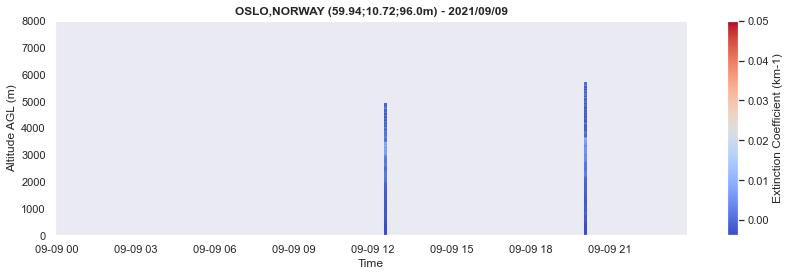

In [2]:
profiles.klett_inversion(time_avg=10, zmin=4000, zmax=6000, remove_outliers=False, verbose=True)
profiles.plot(var='ext', zmax=8000, vmax=5e-2)

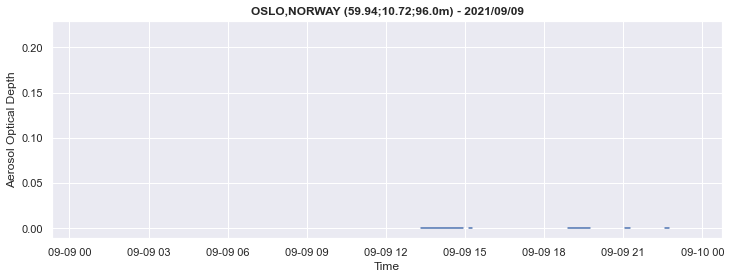

In [3]:
profiles.plot(var='aod')

100%|██████████| 273/273 [00:01<00:00, 175.72it/s]


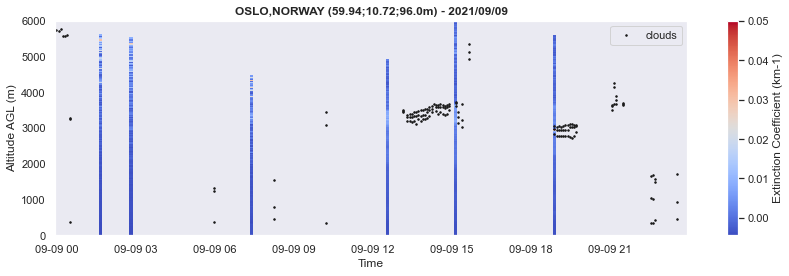

In [8]:
profiles.klett_inversion(time_avg=20, under_clouds=False, verbose=True)
profiles.plot(var='ext', zmax=6000, vmax=5e-2, show_clouds=True)

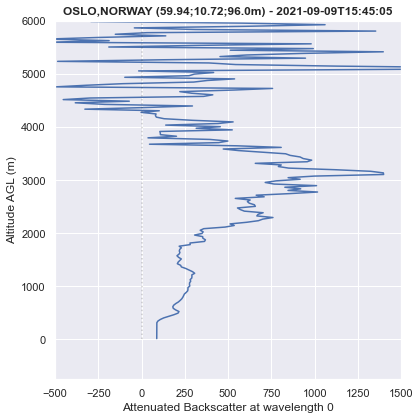

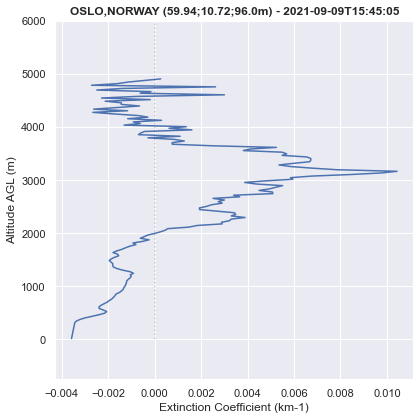

In [15]:
datetime = np.datetime64('2021-09-09T15:45:00')
profiles.plot(datetime=datetime, zmax=6000, vmin=-500, vmax=1500)
profiles.plot(var='ext', datetime=datetime, zmax=6000)

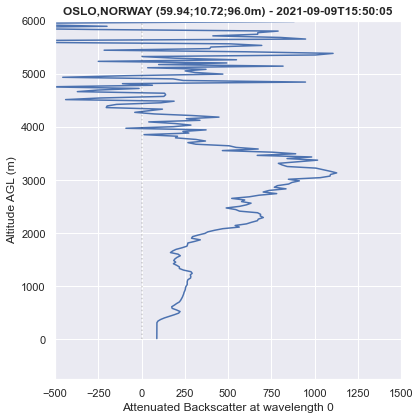

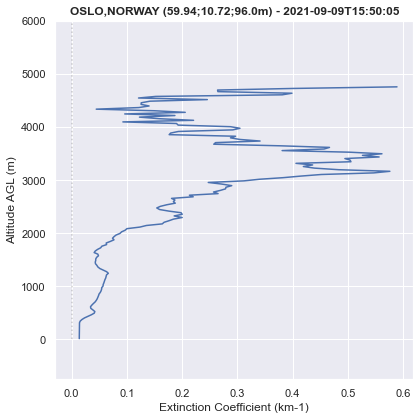

In [14]:
datetime = np.datetime64('2021-09-09T15:50:00')
profiles.plot(datetime=datetime, zmax=6000, vmin=-500, vmax=1500)
profiles.plot(var='ext', datetime=datetime, zmax=6000)

In [49]:
np.nancumsum(profiles.data.ext.data[3,:]*profiles._get_resolution('altitude'))[-1]

-0.3492404868483775

In [35]:
self = profiles
time_avg = 60
under_clouds = True
zmin = 4000
zmax = 6000
apriori={'lr': 50.}

In [11]:
def _iref(data, imin, imax):
    #function that returns best index to be used for initializing the Klett inversion
    
    #it is important to copy the data not to modify it outside of the function
    import copy
    data = data.copy()

    if imin<imax:
        #limit from imin to imax
        maxdata = np.nanmax(data)
        data[0:imin] = maxdata
        data[imax:] = maxdata
        
        #running average
        from scipy.ndimage.filters import uniform_filter1d
        avg_data = uniform_filter1d(data, size=3)

        #get minimum from the averaged signal
        ilow = np.nanargmin(avg_data)

        #around minimum, get index of closest signal to average signal
        n_around_min = 3
        iclose = np.nanargmin(abs(data[ilow-n_around_min:ilow+n_around_min] - avg_data[ilow-n_around_min:ilow+n_around_min]))
        
        return ilow+iclose
    else:
        return None

In [15]:
#we work on profiles averaged in time to reduce the noise
rcs = self.data.attenuated_backscatter_0
t_avg = time_avg * 60 #s
#time resolution in profiles data
dt_s = self._get_resolution('time')
#number of timestamps to be averaged
nt_avg = max([1,round(t_avg/dt_s)])


#if clouds detected, set to nan profiles where cloud is found below 4000m
lowest_clouds = self._get_lowest_clouds()
for i in range(len(self.data.time.data)):
    if lowest_clouds[i]<=4000:
        rcs.data[i,:] = [np.nan for _ in rcs[i,:]]

#if under_clouds, check if clouds_bases is available
if under_clouds and 'clouds_bases' in list(self.data.data_vars):
    lowest_clouds = self._get_lowest_clouds()
elif under_clouds and not 'clouds_bases' in list(self.data.data_vars):
    import warnings
    warnings.warn("under_clouds parameter sets to True (defaults value) when the clouds detection has not been applied to ProfileData object.")
    lowest_clouds = [np.nan for i in np.arange(len(self.data.time))]
else:
    lowest_clouds = [np.nan for i in np.arange(len(self.data.time))]

rcs = rcs.rolling(time=nt_avg, min_periods=1, center=True).median()

#aerosol retrieval requires a molecular profile
altitude = self.data.altitude.data
wavelength = self.data.l0_wavelength.data
rayleigh = apro.rayleigh.Rayleigh(altitude, T0=298, P0=1013, wavelength=wavelength);

#aerosol inversion
ext = []

#for i in (tqdm(range(len(self.data.time.data))) if verbose else range(len(self.data.time.data))):
i = 90

#reference altitude
lowest_cloud_agl = lowest_clouds[i] - self.data.station_altitude.data
imin = self._get_index_from_altitude_AGL(zmin)
imax = self._get_index_from_altitude_AGL(np.min([zmax, lowest_cloud_agl]))
iref = _iref(rcs.data[i,:], imin, imax)

#klett inversion
#ext.append(klett(rcs[i,:], iref, method, apriori, rayleigh))
data = rcs.data[i,:]
method = 'backward'
apriori = {'lr': 50}

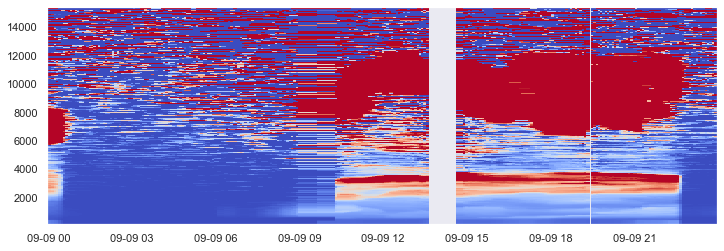

In [16]:
time = self.data.time.data
altitude = self.data.altitude.data
C = np.transpose(rcs.data)

fig, axs = plt.subplots(1, 1, figsize=(12, 4))
plt.pcolormesh(time, altitude, C, vmin=10, vmax=1000, shading='nearest', cmap='coolwarm')

In [22]:
import math

#initialize ext array
ext = [np.nan for _ in range(len(data))]

#calculation
lr_aer = apriori['lr']
lr_mol = 8.0*math.pi/3.

#vertical resolution
dz = min(np.diff(rayleigh.altitude))

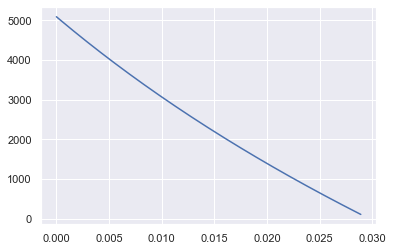

In [23]:
#int1(1:Nref)=cumsum((Saer_OK-Smol)*beta_mol(1:Nref)*resol)
int1 = np.cumsum((lr_aer-lr_mol)*rayleigh.backscatter[:iref]*dz)
#for i=1:Nref
#    int1(i)=2*int1($)-2*int1(i)
#end
int1 = [2*int1[-1] - 2*int1[i] for i in range(iref)]
plt.plot(int1, altitude[0:iref])

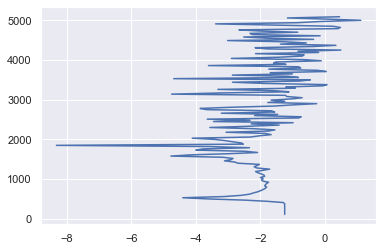

In [24]:
#for i=1:Nref
#    PHI(i)=(log(X(i)/X(Nref)) + int1(i))
#end
phi = [np.log(abs(data[i]/data[iref])) + int1[i] for i in range(iref)]
plt.plot(phi, altitude[0:iref])

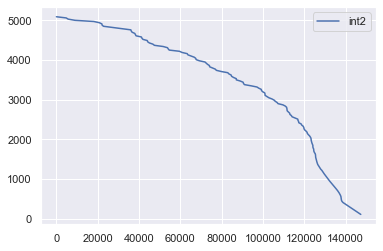

In [25]:
#int2=2*cumsum(Saer_OK*exp(PHI(1:Nref))*resol)
int2 = 2*np.nancumsum(lr_aer*np.exp(phi)*dz)
#for i=1:Nref
#    int2(i)=int2($)-int2(i)
#end
int2 = [int2[-1] - int2[i] for i in range(iref)]
plt.plot(int2, altitude[:iref], label='int2')
plt.legend()

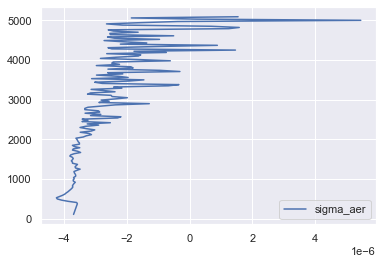

In [27]:
#initialize total backscatter
back_aer_iref = 0 #m-1
beta_tot_iref = rayleigh.backscatter[iref] + back_aer_iref

#for i=1:Nref-1
#    BETA(i)=( exp(PHI(i)) ) / ( (1/BETA(Nref)) + int2(i) )
#end

beta_tot = [np.exp(phi[i])/((1/beta_tot_iref)+int2[i]) for i in range(iref)]
beta_aer = beta_tot - rayleigh.backscatter[:iref]

sigma_aer=lr_aer*beta_aer
#plt.plot(beta_tot, altitude[:iref], label='beta_tot')
#plt.plot(beta_aer, altitude[:iref], label='beta_aer')
plt.plot(sigma_aer, altitude[:iref], label='sigma_aer')
plt.legend()

In [10]:
import aprofiles as apro
import numpy as np
import matplotlib.pyplot as plt

#path = "examples/data/L2_0-20000-006735_A20210908.nc"
path = "examples/data/L2_0-20000-001492_A20210909.nc"
#path = "data/e-profile/2021/09/09/L2_0-20008-0MEL_A20210909.nc"
apro_reader = apro.reader.ReadProfiles(path)
profiles = apro_reader.read()

In [14]:
profiles.data

<xarray.Dataset>
Dimensions:                          (altitude: 511, layer: 3, time: 273)
Coordinates:
  * time                             (time) datetime64[ns] 2021-09-09T00:00:04 ... 2021-09-09T23:55:06
  * altitude                         (altitude) float64 111.0 ... 1.541e+04
Dimensions without coordinates: layer
Data variables:
    start_time                       (time) datetime64[ns] ...
    latitude                         (time, altitude) float64 ...
    longitude                        (time, altitude) float64 ...
    attenuated_backscatter_0         (time, altitude) float64 ...
    uncertainties_att_backscatter_0  (time, altitude) float64 ...
    l0_wavelength                    float64 ...
    station_longitude                float64 ...
    station_latitude                 float64 ...
    station_altitude                 float64 ...
    quality_flag                     (time, altitude) int64 ...
    vertical_visibility              (time) float64 ...
    cloud_base_heigh